In [1]:
# Sample API
import flowx
import simulation
import numpy
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
flowx.__version__

'0.1.dev'

In [2]:
# Define grid parameters
nx, ny = 400, 200
xmin, xmax = -10.0, 30.0
ymin, ymax = -10.0, 10.0

Re   = 100.0
dt   = 0.01
tmax = 10.

ibm_x = 0.0
ibm_y = 0.0
ibm_r = 0.5

# Define cell-centered variable names
center_vars = ['pres', 'divv']
face_vars   = ['velc', 'hvar']

# Define boundary conditions for variable pressure and velocity [left, right, bottom, top]
bc_type_pres = {'pres': ['neumann', 'neumann', 'neumann', 'neumann']}
bc_val_pres  = {'pres': [0.0, 0.0, 0.0, 0.0]}

bc_type_u = {'velc': ['dirichlet', 'outflow', 'dirichlet', 'dirichlet']}
bc_val_u  = {'velc': [1.0, 0.0, 0.0, 0.0]}

bc_type_v = {'velc': ['dirichlet', 'neumann', 'dirichlet', 'dirichlet']}
bc_val_v  = {'velc': [0.0, 0.0, 0.0, 0.0]}


# Create the grid and data
gridc = flowx.Grid('cell-centered', center_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_pres, user_bc_val=bc_val_pres)

gridx = flowx.Grid('x-face', face_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_u, user_bc_val=bc_val_u)

gridy = flowx.Grid('y-face', face_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_v, user_bc_val=bc_val_v)

scalars = flowx.Scalars(tmax=10.0, dt=0.01, Re=100.0)

In [3]:
simulation.set_initial_velocity(gridc, gridx, gridy, 'velc', 'pres')

------------ Time = 0.0 ---------------
Number of poisson iterations    : None
Final poisson residual : 4.40846516017987e-12
Max, Min, U   : 1.0026317408942778, -1.0
Max, Min, V   : 0.006544137552588087, -0.006544137552588087
Max, Min, P   : 0.8905732242587768, -0.8589583692932419
Max, Min, DIV : 6.990664557643411e-15, -6.7639985409581604e-15




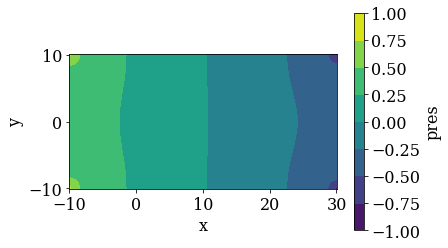

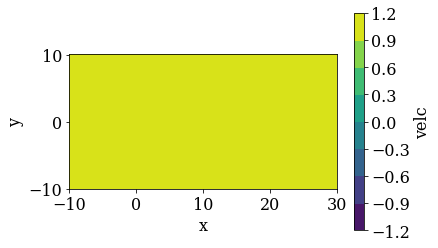

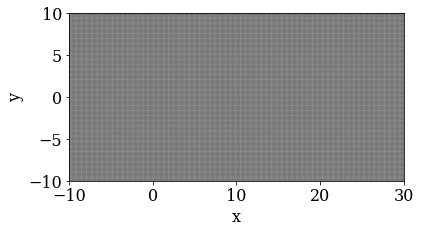

------------ Time = 0.09999999999999999 ---------------
Number of poisson iterations    : None
Final poisson residual : 3.641061280329955e-12
Max, Min, U   : 1.0309803110176237, -1.0
Max, Min, V   : 0.06061370366241117, -0.06061370366241117
Max, Min, P   : 0.787067856451107, -0.5945528114699533
Max, Min, DIV : 6.65158032819857e-15, -7.020751167929884e-15


------------ Time = 0.20000000000000004 ---------------
Number of poisson iterations    : None
Final poisson residual : 3.0829800930944813e-12
Max, Min, U   : 1.0439681039480895, -1.0
Max, Min, V   : 0.08619599333205856, -0.08619599333205845
Max, Min, P   : 0.7105692773575932, -0.4477175431252582
Max, Min, DIV : 6.6761781649868346e-15, -6.691628045944753e-15


------------ Time = 0.3000000000000001 ---------------
Number of poisson iterations    : None
Final poisson residual : 2.660770661824866e-12
Max, Min, U   : 1.0611165925206207, -1.0
Max, Min, V   : 0.10253609731431357, -0.10253609731431344
Max, Min, P   : 0.6560059300323682, -0

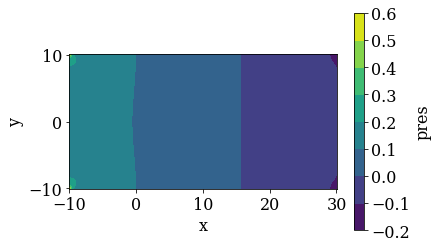

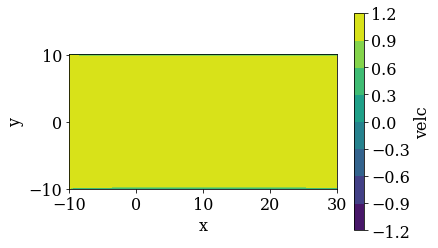

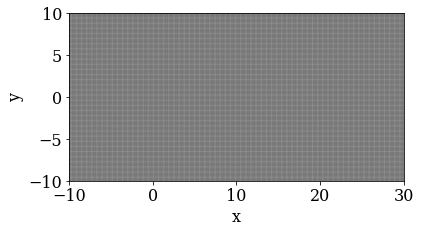

------------ Time = 1.1000000000000008 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.639622711182943e-12
Max, Min, U   : 1.1194249347253808, -1.0
Max, Min, V   : 0.11739241867605897, -0.11739241867605847
Max, Min, P   : 0.5402580866779157, -0.09430585190271877
Max, Min, DIV : 6.6505638886618645e-15, -6.641415932831518e-15


------------ Time = 1.2000000000000008 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.2592328171000163e-12
Max, Min, U   : 1.1216814890642766, -1.0
Max, Min, V   : 0.11836626539256324, -0.11836626539256286
Max, Min, P   : 0.4948597866062587, -0.12525467051613393
Max, Min, DIV : 6.661338147750939e-15, -6.661338147750939e-15


------------ Time = 1.300000000000001 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.2400970402243436e-12
Max, Min, U   : 1.123667877161231, -1.0
Max, Min, V   : 0.11899470065856844, -0.11899470065856813
Max, Min, P   : 0.49791057834022934, 

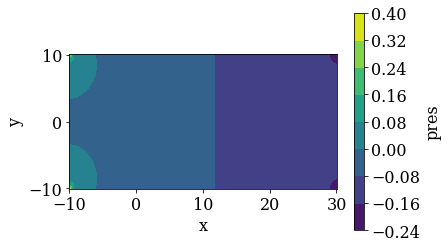

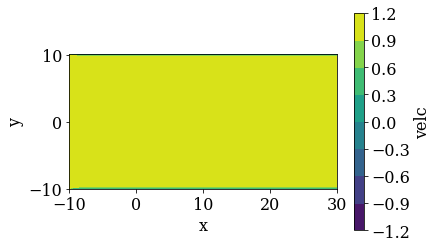

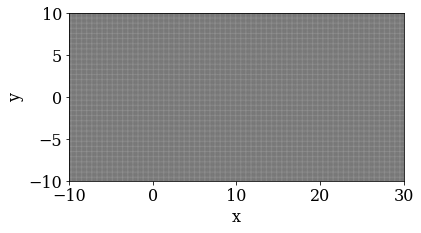

------------ Time = 2.099999999999999 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.7244561492866917e-12
Max, Min, U   : 1.1274312202060046, -1.0
Max, Min, V   : 0.1199905137062683, -0.11999051370626838
Max, Min, P   : 0.38216497276788025, -0.17110736879652833
Max, Min, DIV : 6.765421556309548e-15, -6.7307101461310664e-15


------------ Time = 2.199999999999997 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.5344934818795974e-12
Max, Min, U   : 1.1277671499764597, -1.0
Max, Min, V   : 0.12004870504028337, -0.12004870504028327
Max, Min, P   : 0.39203553740541885, -0.15724822006666253
Max, Min, DIV : 6.628812082576374e-15, -6.807705441036482e-15


------------ Time = 2.299999999999995 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.5081534557158961e-12
Max, Min, U   : 1.1280905777333747, -1.0
Max, Min, V   : 0.12010438907555415, -0.1201043890755541
Max, Min, P   : 0.3912385522049569, -

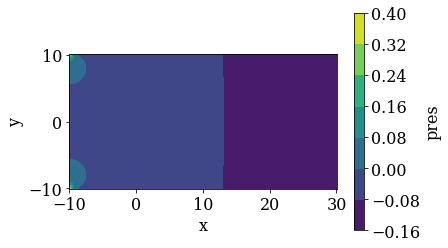

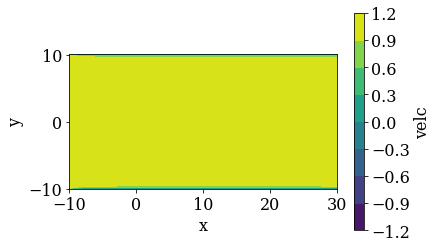

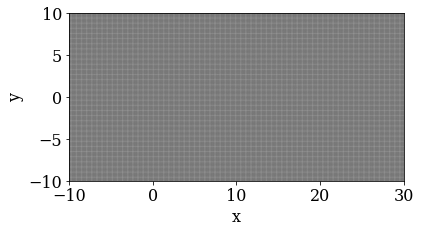

------------ Time = 3.099999999999978 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.6771664768577931e-12
Max, Min, U   : 1.1281239557910006, -1.0
Max, Min, V   : 0.12039953475141481, -0.1203995347514148
Max, Min, P   : 0.3703661546121985, -0.15441793921489277
Max, Min, DIV : 6.693864212925504e-15, -6.765421556309548e-15


------------ Time = 3.1999999999999758 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.3498530579859662e-12
Max, Min, U   : 1.1280745002709531, -1.0
Max, Min, V   : 0.1204219156381647, -0.12042191563816465
Max, Min, P   : 0.3880120586993776, -0.13486818219179264
Max, Min, DIV : 6.757290040015906e-15, -6.7263902781000695e-15


------------ Time = 3.2999999999999736 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.0407102377985274e-12
Max, Min, U   : 1.1280126074480574, -1.0
Max, Min, V   : 0.1204420267462422, -0.12044202674624238
Max, Min, P   : 0.4079398276006852, -0

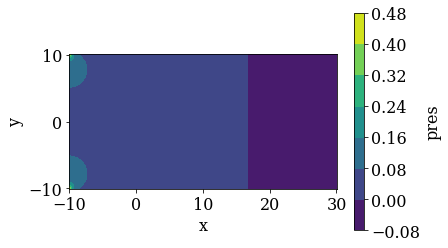

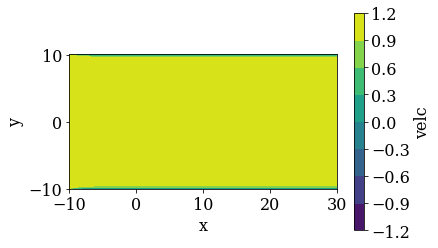

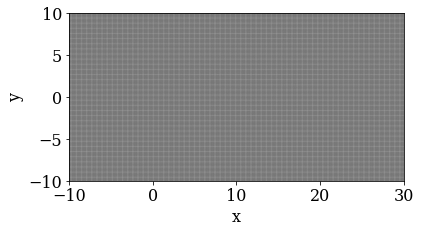

------------ Time = 4.099999999999957 ---------------
Number of poisson iterations    : None
Final poisson residual : 9.598711939508511e-13
Max, Min, U   : 1.127618416232031, -1.0
Max, Min, V   : 0.12055599386786428, -0.12055599386786396
Max, Min, P   : 0.4769380654376701, -0.03275444730085969
Max, Min, DIV : 6.7133798520302435e-15, -6.661338147750939e-15


------------ Time = 4.199999999999955 ---------------
Number of poisson iterations    : None
Final poisson residual : 7.413156302959777e-13
Max, Min, U   : 1.1275780600562748, -1.0
Max, Min, V   : 0.12056603000970198, -0.12056603000970181
Max, Min, P   : 0.4591604561174668, -0.049389034335676506
Max, Min, DIV : 6.6629644510096675e-15, -6.648327721681113e-15


------------ Time = 4.299999999999953 ---------------
Number of poisson iterations    : None
Final poisson residual : 9.075007264557829e-13
Max, Min, U   : 1.127540348356308, -1.0
Max, Min, V   : 0.12057541296254605, -0.12057541296254597
Max, Min, P   : 0.47358963684502925, -0.

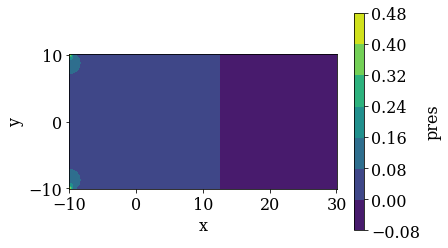

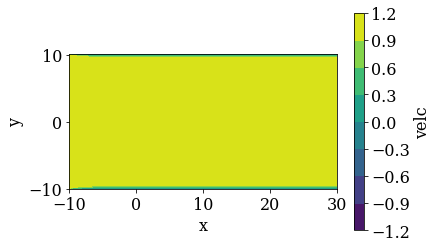

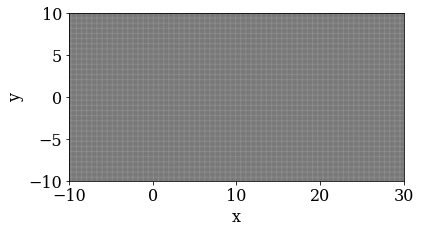

------------ Time = 5.099999999999936 ---------------
Number of poisson iterations    : None
Final poisson residual : 7.219012582114019e-13
Max, Min, U   : 1.1272899661135762, -1.0
Max, Min, V   : 0.12063219280833916, -0.12063219280833927
Max, Min, P   : 0.45884347072840087, -0.0412474495903598
Max, Min, DIV : 6.7133798520302435e-15, -6.664590754268396e-15


------------ Time = 5.199999999999934 ---------------
Number of poisson iterations    : None
Final poisson residual : 8.038260686422535e-13
Max, Min, U   : 1.1272646644112463, -1.0
Max, Min, V   : 0.12063757056206637, -0.12063757056206664
Max, Min, P   : 0.4657330104670717, -0.03358060764614114
Max, Min, DIV : 6.661338147750939e-15, -6.615801656506548e-15


------------ Time = 5.299999999999931 ---------------
Number of poisson iterations    : None
Final poisson residual : 8.332283565857904e-13
Max, Min, U   : 1.12724046456038, -1.0
Max, Min, V   : 0.12064265794096903, -0.12064265794096915
Max, Min, P   : 0.4683571726066978, -0.030

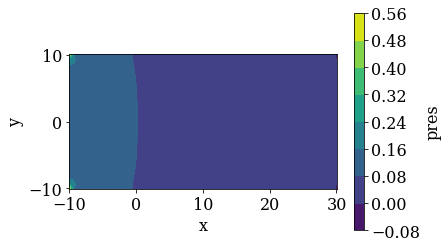

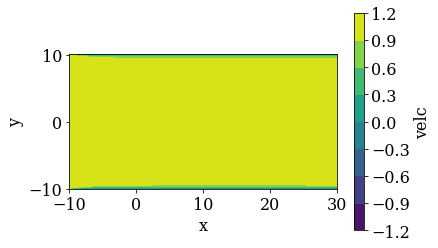

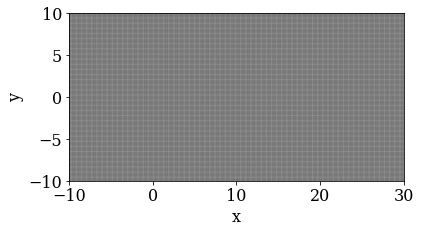

------------ Time = 6.099999999999914 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.061337440525766e-12
Max, Min, U   : 1.127081701888933, -1.0
Max, Min, V   : 0.12067504552759008, -0.1206750455275903
Max, Min, P   : 0.48313878382777936, -0.010217396202053877
Max, Min, DIV : 6.661338147750939e-15, -6.664590754268396e-15


------------ Time = 6.199999999999912 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.2107209501398283e-12
Max, Min, U   : 1.1270654400659645, -1.0
Max, Min, V   : 0.12067826455772239, -0.12067826455772261
Max, Min, P   : 0.4924126856889028, -0.0003783266154652253
Max, Min, DIV : 6.7263902781000695e-15, -6.661338147750939e-15


------------ Time = 6.29999999999991 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.4443265225408441e-12
Max, Min, U   : 1.1270498385390977, -1.0
Max, Min, V   : 0.1206813362685884, -0.12068133626858861
Max, Min, P   : 0.5051437265092801, 0.

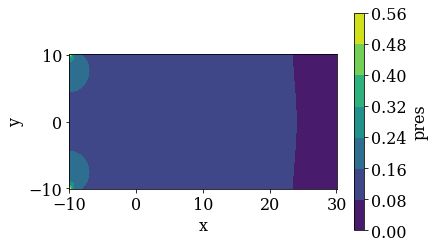

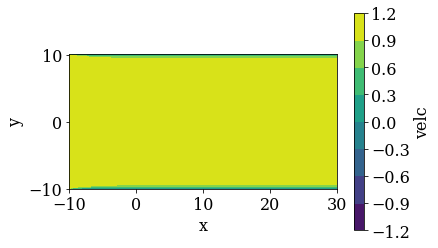

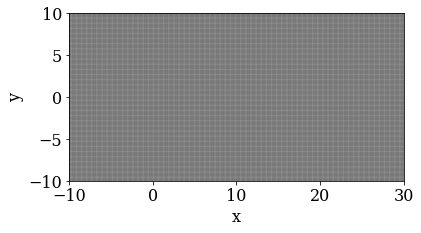

------------ Time = 7.099999999999893 ---------------
Number of poisson iterations    : None
Final poisson residual : 2.115692969347187e-12
Max, Min, U   : 1.1269451773029604, -1.0
Max, Min, V   : 0.12070154314966632, -0.12070154314966604
Max, Min, P   : 0.5421815914916263, 0.05381603362347853
Max, Min, DIV : 6.7789910241245616e-15, -6.661338147750939e-15


------------ Time = 7.199999999999891 ---------------
Number of poisson iterations    : None
Final poisson residual : 2.1050349679999162e-12
Max, Min, U   : 1.1269342308819195, -1.0
Max, Min, V   : 0.12070361876322931, -0.12070361876322891
Max, Min, P   : 0.5404841628872716, 0.05254678197119509
Max, Min, DIV : 6.869504964868156e-15, -6.869504964868156e-15


------------ Time = 7.299999999999889 ---------------
Number of poisson iterations    : None
Final poisson residual : 2.3314668881454628e-12
Max, Min, U   : 1.1269236864235415, -1.0
Max, Min, V   : 0.12070561173017576, -0.1207056117301754
Max, Min, P   : 0.5532691144710216, 0.065

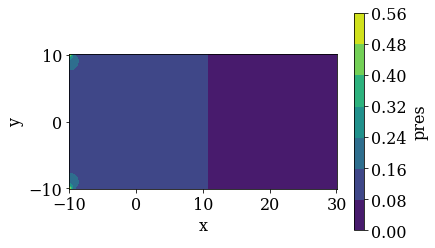

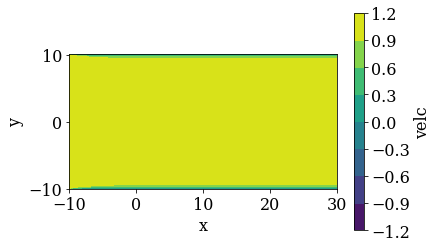

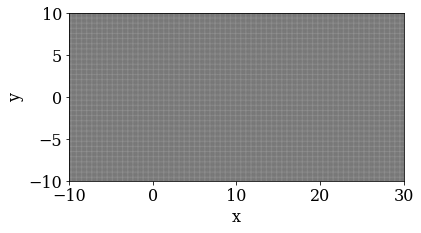

------------ Time = 8.099999999999872 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.7440254198788842e-12
Max, Min, U   : 1.126851752515044, -1.0
Max, Min, V   : 0.12071904154408526, -0.12071904154408543
Max, Min, P   : 0.5209716906872285, 0.03642395285253593
Max, Min, DIV : 6.758916343274635e-15, -6.669388348881644e-15


------------ Time = 8.19999999999987 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.6598522293888892e-12
Max, Min, U   : 1.1268440948398832, -1.0
Max, Min, V   : 0.12072045448897917, -0.12072045448897921
Max, Min, P   : 0.5166618101569924, 0.03244615164787068
Max, Min, DIV : 6.661338147750939e-15, -6.648327721681113e-15


------------ Time = 8.299999999999867 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.2993786138366993e-12
Max, Min, U   : 1.1268366918890904, -1.0
Max, Min, V   : 0.12072181743035375, -0.12072181743035398
Max, Min, P   : 0.4964687302002585, 0.0125

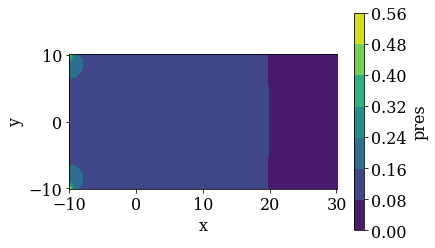

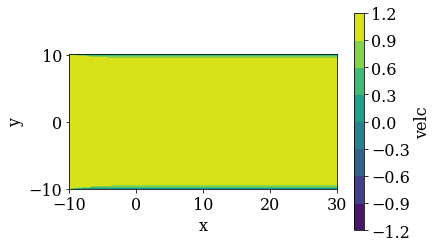

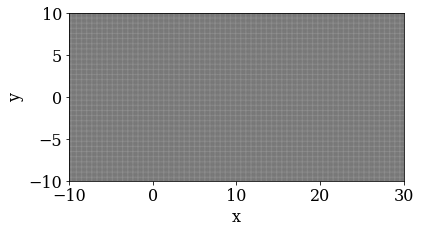

------------ Time = 9.09999999999985 ---------------
Number of poisson iterations    : None
Final poisson residual : 2.284471529009311e-12
Max, Min, U   : 1.126785457433024, -1.0
Max, Min, V   : 0.12073117042429886, -0.12073117042429866
Max, Min, P   : 0.5495940573972323, 0.06804254305110857
Max, Min, DIV : 6.661338147750939e-15, -6.684106393373135e-15


------------ Time = 9.199999999999848 ---------------
Number of poisson iterations    : None
Final poisson residual : 2.7349894070838983e-12
Max, Min, U   : 1.1267799232289768, -1.0
Max, Min, V   : 0.12073217247198172, -0.12073217247198181
Max, Min, P   : 0.5732875783785473, 0.09199973305898823
Max, Min, DIV : 6.882515390937982e-15, -6.7914424084492e-15


------------ Time = 9.299999999999846 ---------------
Number of poisson iterations    : None
Final poisson residual : 2.600103720643392e-12
Max, Min, U   : 1.126774557528779, -1.0
Max, Min, V   : 0.12073314249158486, -0.12073314249158504
Max, Min, P   : 0.5661942870317703, 0.085164299

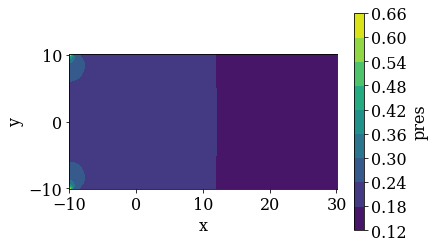

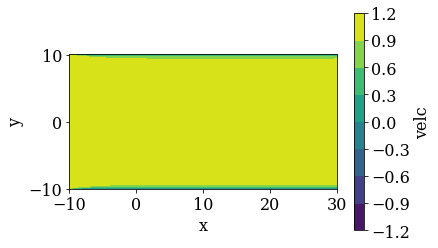

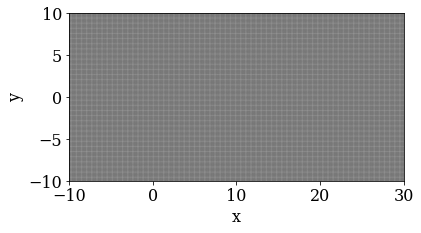

In [4]:
ins_vars = ['velc', 'hvar', 'divv', 'pres']

poisson_options = dict(maxiter = 2000, tol = 1e-9)
poisson_options['lu'], poisson_options['mtx'] = flowx.poisson.build_sparse(gridc, 'pres')

while scalars.variable['time'] <= scalars.variable['tmax']:
    
    
    
    for i in range (0,3):
        # Compute mass in the domain
        Qin = (simulation.get_qin(gridx, 'velc', bc_type_u['velc']) +
           simulation.get_qin(gridy, 'velc', bc_type_v['velc']))
    
       # Update the outflow boundary velocity using a convective equation.
        simulation.update_outflow_bc(gridx, 'velc', dt)
    
        # Predictor Step
        flowx.ins.rk3(gridc, gridx, gridy, scalars, ins_vars, 'predictor',i=i)

        # Divergence Step
        flowx.ins.rk3(gridc, gridx, gridy, scalars, ins_vars, 'divergence',i=i)
        
        # Compute mass out of the domain
        Qout = (simulation.get_qout(gridx, 'velc', bc_type_u['velc']) +
            simulation.get_qout(gridy, 'velc', bc_type_v['velc']))
        
        # Rescale velocity at outflow and update BC for corrector step
        simulation.rescale_velocity(gridx, 'velc', bc_type_u['velc'],
                                Qin, Qout) 
        simulation.update_outflow_bc(gridx, 'velc', dt, convvel=0.0)
    
        # Solve the pressure Poisson equation 
        scalars.stats['ites'], scalars.stats['res'] = flowx.poisson.solve_lu(gridc, 'pres', 'divv', 
                                                                             poisson_options)
    
        # Corrector Step
        flowx.ins.rk3(gridc, gridx, gridy, scalars, ins_vars, 'corrector',i=i)
    
    # Display stats
    if scalars.variable['nstep'] % 10 == 0:
        flowx.io.display_stats(scalars)  
        
    if scalars.variable['nstep'] % 100 == 0:
        flowx.io.plot_contour(gridc, 'pres')
        flowx.io.plot_contour(gridx, 'velc')
        flowx.io.plot_vector(gridx,gridy,'velc')
              
    scalars.advance()

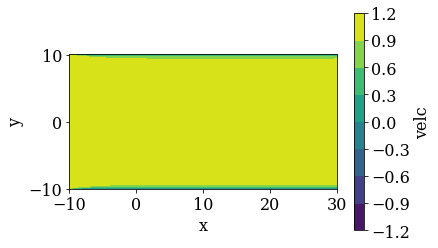

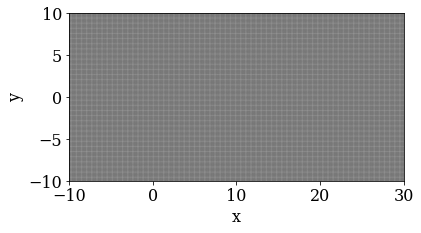

In [6]:
#%matplotlib notebook
flowx.io.plot_contour(gridx, 'velc')
flowx.io.plot_vector(gridx,gridy,'velc')
